In [1]:
import networkx as nx

import numpy as np
import pandas as pd

import random
import math

import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sn

from sklearn.ensemble import RandomForestClassifier

In [2]:
# hyperparameters

seed = random.randint(1, 1000)         # random seed

# Feature importance

Here we will compare the feature importance of link reconstruction model and quality classification model. We will use the `RandomForestClassifier` for fair comparison. 

We use features and dataset from 'Optimal Link Prediction' paper by Amir Ghasemian et al.
(https://www.pnas.org/content/117/38/23393)

## Step 1
Generating or importing a graph, train/test splitting

In [3]:
from lib.generators.LFR import LFR
from lib.generators.OLP import OLP


generator = OLP(
    network_name='Email_network_Uni_R-V_Spain_Email_network_Uni_R-V_Spain', 
    seed=seed
)
feature_names = generator.feature_names

link_prediction_train, link_prediction_test, classifier_test = generator.TRAIN1_DF, generator.TEST1_DF, generator.TEST2_DF

Loading file...
Network info:

title: Email network (Uni. R-V, Spain, 2003)
description: A network representing the exchange of emails among members of the Rovira i Virgili University in Spain, in 2003. The KONECT version is undirected.
networkDomain: Social
subDomain: Communication
citation: R. Guimera, L. Danon, A. Diaz-Guilera, F. Giralt and A. Arenas, "Self-similar community structure in a network of human interactions." Physical Review E 68, 065103(R) (2003).
sourceUrl: http://deim.urv.cat/~alexandre.arenas/publicacions/pdf/email.pdf

File loaded!
Calculating features...
Features calculated!
Train/test splitting...
Done splitting the data!


## Step 2
Link prediction model

In [4]:
model = RandomForestClassifier(n_estimators=100, max_depth=3, random_state=seed)
model.fit(link_prediction_train[feature_names], link_prediction_train['goal'])

prob = model.predict_proba(link_prediction_test[feature_names])[:, 1]
prob = pd.Series(prob, name='prob')

link_proba = link_prediction_train.join(prob)

## Step 3
Quality classification model

In [5]:
# absolute eroor of prediction
link_proba['abs_error'] = link_proba.apply(lambda row: math.fabs(row['goal']-row['prob']), axis=1)
link_proba.head()

train_median_error = link_proba['abs_error'].median()
train_median_error

link_proba['quality_label'] = link_proba.apply(lambda row: 1 if row['abs_error'] <= train_median_error else 0, axis=1)

In [6]:
model_2 = RandomForestClassifier(n_estimators=100, max_depth=3, random_state=seed)
model_2.fit(link_proba[feature_names], link_proba['quality_label'])

RandomForestClassifier(max_depth=3, random_state=389)

## Step 4

Feature importance comparisons

In [7]:
importances_pd = pd.DataFrame()
importances_pd['Reconstruction feature importance'] = pd.Series(model.feature_importances_, index=feature_names)
importances_pd['Classification feature importance'] = pd.Series(model_2.feature_importances_, index=feature_names)
importances_pd['Diff'] = importances_pd.apply(lambda x: math.fabs(x['Reconstruction feature importance'] - x['Classification feature importance']), axis=1)

importances_pd

,Reconstruction feature importance,Classification feature importance,Diff
com_ne,0.022393,0.024028,0.001635
short_path,0.175980,0.109895,0.066086
LHN,0.034687,0.066226,0.031539
page_rank_pers_edges,0.357601,0.334877,0.022724
pref_attach,0.040770,0.056473,0.015702
jacc_coeff,0.047937,0.044879,0.003057
adam_adar,0.071485,0.085362,0.013878
res_alloc_ind,0.165407,0.192566,0.027159
svd_edges,0.000000,0.000000,0.000000
svd_edges_dot,0.036578,0.028000,0.008578


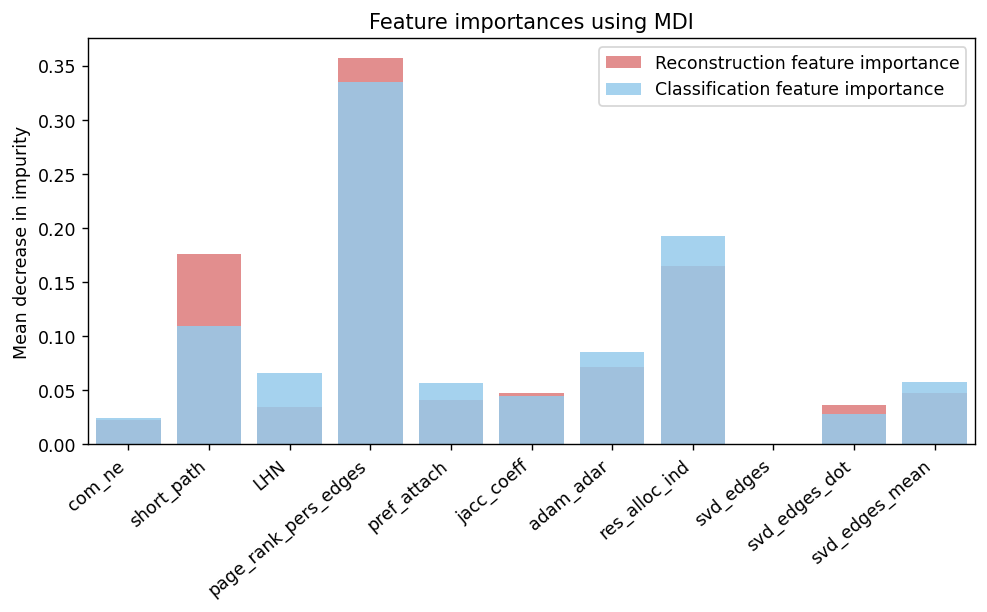

In [8]:
mpl.rcParams['figure.figsize'] = [8, 5]
mpl.rcParams['figure.dpi'] = 125

fig, ax = plt.subplots()

sn.barplot(
    data=importances_pd, 
    x=feature_names, 
    y='Reconstruction feature importance', 
    label='Reconstruction feature importance',
    ax=ax, 
    color='lightcoral', 
    alpha=1
)

sn.barplot(
    data=importances_pd, 
    x=feature_names, 
    y='Classification feature importance', 
    label='Classification feature importance', 
    ax=ax, 
    color='lightskyblue', 
    alpha=0.85
)

ax.set_title("Feature importances using MDI")
ax.set_ylabel("Mean decrease in impurity")
ax.set_xticklabels(ax.get_xticklabels(), rotation=40, ha="right")
ax.legend()

fig.tight_layout()